In [ ]:
# %%bash
# ────────────────────────────────────────────────────────────
# Minimal package bootstrap  (only what we really use)
# ────────────────────────────────────────────────────────────
%pip install -qU "trino[sqlalchemy]==0.332.0" polars matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Imports
# ────────────────────────────────────────────────────────────
import os
import re
import json
import datetime as dt
from pathlib import Path
from typing import Tuple, Optional

import pandas as pd
import numpy as np        # Integrated: for datetime type checking
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sqlalchemy.engine import create_engine


In [ ]:

# ────────────────────────────────────────────────────────────
# Helper: robust host:port parser with TCP‑range clamp
# ────────────────────────────────────────────────────────────
def _parse_host_port(host: Optional[str], port: Optional[str],
                     default_port: int = 8080) -> Tuple[str, int]:
    host = (host or "").strip()
    port = (port or "").strip()
    host = re.sub(r"^(?:https?|tcp)://", "", host, flags=re.I)  # strip scheme
    if ":" in host and not port:
        host, port = host.split(":", 1)
    try:
        port_int = int(re.sub(r"\D", "", port))
    except ValueError:
        port_int = default_port
    if not (1 <= port_int <= 65_535):
        port_int = default_port
    return host or "localhost", port_int


In [ ]:

# ────────────────────────────────────────────────────────────
# Environment variables (override in shell if needed)
# ────────────────────────────────────────────────────────────
TRINO_HOST, TRINO_PORT = _parse_host_port(
    os.getenv("TRINO_HOST"),
    os.getenv("TRINO_PORT"),
)
TRINO_USER    = os.getenv("TRINO_USER",    "jupyter")
TRINO_CATALOG = os.getenv("TRINO_CATALOG", "iceberg")
TRINO_SCHEMA  = os.getenv("TRINO_SCHEMA")          # optional

print(f"🔌 Trino → {TRINO_HOST}:{TRINO_PORT}  catalog={TRINO_CATALOG!r} "
      f"(requested schema={TRINO_SCHEMA or '❓ auto‑detect'})")


🔌 Trino → trino:8080  catalog='iceberg' (requested schema=❓ auto‑detect)


In [ ]:

# ────────────────────────────────────────────────────────────
# JSON + plotting helpers  (extended with auto‑date formatting)
# ────────────────────────────────────────────────────────────
def _json_default(value):
    if isinstance(value, (dt.datetime, dt.date)):
        return value.isoformat()
    return repr(value)

def save_dict(d: dict, path: Path):
    path.write_text(json.dumps(d, default=_json_default))

def load_dict(path: Path) -> dict:
    return json.loads(path.read_text())

def df_from_data_d(data_d: dict) -> pl.DataFrame:
    """Recreate Polars DataFrame; parse 'date' back to datetime."""
    return pl.DataFrame(data_d, schema_overrides={"date": pl.Datetime})

def _maybe_format_date_axis(ax, x_values):
    """
    If *x_values* looks like datetime, install an AutoDateLocator and a DateFormatter
    with 'DD-MM-YYYY' format on tick labels to avoid clutter.
    """
    # Accept pandas Series, numpy array, or Polars Series
    if hasattr(x_values, "to_numpy"):
        x_array = x_values.to_numpy()
    else:
        x_array = x_values

    # Determine if x_array contains datetime values (check dtype or first element)
    first_elem = None
    if hasattr(x_array, "__len__") and len(x_array) > 0:
        try:
            first_elem = x_array[0]
        except Exception:
            try:
                first_elem = next(iter(x_array))
            except StopIteration:
                first_elem = None

    if pd.api.types.is_datetime64_any_dtype(x_array) or isinstance(first_elem, (pd.Timestamp, np.datetime64)):
        # Use AutoDateLocator for smart date tick spacing
        locator   = mdates.AutoDateLocator()
        # Use DateFormatter for fixed "DD-MM-YYYY" format on tick labels
        formatter = mdates.DateFormatter('%d-%m-%Y')
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        # Rotate and align date labels for readability (auto-format)
        ax.figure.autofmt_xdate()

def plot_from_d(data, plot_d: dict, ax, **kwargs):
    """
    Generic plotting helper (bar, line, scatter, diff) that automatically
    prettifies a datetime x‑axis.
    """
    chart = plot_d["chart_type"]
    x_key = plot_d["x_data"]

    if chart == "bar":
        ax.bar(x_key, plot_d["y_data"], data=data, **kwargs)
    elif chart == "line":
        ax.plot(x_key, plot_d["y_data"], data=data, **kwargs)
    elif chart == "scatter":
        ax.scatter(x_key, plot_d["y_data"], data=data, **kwargs)
    elif chart == "diff":
        plot_data = pl.DataFrame(data) if not isinstance(data, pl.DataFrame) else data
        plot_data = plot_data.with_columns(
            x   = pl.col(x_key),
            pos = pl.col(plot_d["pos_y_data"]),
            neg = -pl.col(plot_d["neg_y_data"])
        ).with_columns(diff = pl.col("pos") + pl.col("neg"))
        ax.bar("x", "pos", data=plot_data, fc="seagreen", **kwargs)
        ax.bar("x", "neg", data=plot_data, fc="indianred", **kwargs)
        ax.plot("x", "diff", data=plot_data, c="k", ls="--")
        ax.set_yticks(ax.get_yticks(),
                      [int(abs(t)) for t in ax.get_yticks()])

    # Labels, scales
    ax.set_xlabel(plot_d.get("xlabel"))
    ax.set_ylabel(plot_d.get("ylabel"))
    ax.set_title(plot_d.get("title"), fontsize=14)
    ax.set_xscale(plot_d.get("xscale", "linear"))
    ax.set_yscale(plot_d.get("yscale", "linear"))

    # Auto‑date formatting (apply date formatter if needed)
    _maybe_format_date_axis(ax, data[x_key])

    return ax


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Locate schema containing collected_news
# ────────────────────────────────────────────────────────────
TARGET_TABLE = "collected_news"
engine_cat = create_engine(
    f"trino://{TRINO_USER}@{TRINO_HOST}:{TRINO_PORT}/{TRINO_CATALOG}"
)

def find_schema_with_table(engine, catalog: str,
                           table: str,
                           preferred: Optional[str] = None) -> str:
    with engine.connect() as conn:
        schemas = pd.read_sql(f"SHOW SCHEMAS FROM {catalog}", conn)["Schema"].tolist()
        if preferred:
            if preferred not in schemas:
                raise ValueError(f"Schema '{preferred}' not found in catalog '{catalog}'. "
                                 f"Available: {schemas}")
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{preferred}", conn)["Table"].tolist()
            if table not in tables:
                raise ValueError(f"Table '{table}' not found in schema '{preferred}'.")
            return preferred
        for sch in schemas:
            tables = pd.read_sql(f"SHOW TABLES FROM {catalog}.{sch}", conn)["Table"].tolist()
            if table in tables:
                return sch
    raise ValueError(f"Table '{table}' not found in any schema of catalog '{catalog}'.")

ACTIVE_SCHEMA = find_schema_with_table(engine_cat, TRINO_CATALOG,
                                       TARGET_TABLE, TRINO_SCHEMA)
print(f"✅ Using schema → {ACTIVE_SCHEMA!r}")


✅ Using schema → 'news'


In [ ]:
# %%
# ────────────────────────────────────────────────────────────
# Retrieve the data
# ────────────────────────────────────────────────────────────
COLUMNS_NEEDED = [
    "url", "publish_date", "created_at", "language",
    "topic", "keyword", "domain", "sourcecountry",
]

TABLE_FQN   = f"{TRINO_CATALOG}.{ACTIVE_SCHEMA}.{TARGET_TABLE}"
DATE_FILTER = ""  # Supply a predicate like:  WHERE publish_date >= DATE '2025‑01‑01'
SQL = f"""
SELECT {', '.join(COLUMNS_NEEDED)}
FROM   {TABLE_FQN}
{DATE_FILTER}
"""

with engine_cat.connect() as conn:
    df_raw = pd.read_sql(SQL, conn)

print(f"✅ Retrieved {len(df_raw):,} rows")


✅ Retrieved 190,760 rows


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# Timestamp clean‑up + deduplication
# ────────────────────────────────────────────────────────────
for col in ("publish_date", "created_at"):
    df_raw[col] = (
        pd.to_datetime(df_raw[col], errors="coerce", utc=True)
          .dt.tz_localize(None)
    )

df_dedup = df_raw.drop_duplicates(subset="url").reset_index(drop=True)
print(f"📉 After deduplication: {len(df_dedup):,} unique URLs "
      f"({len(df_raw) - len(df_dedup):,} duplicates removed)")


📉 After deduplication: 141,476 unique URLs (49,284 duplicates removed)


In [ ]:
# %%
# ────────────────────────────────────────────────────────────
# DAILY news counts
# ────────────────────────────────────────────────────────────
WINDOW_START = pd.to_datetime("2025-03-07")
WINDOW_END   = pd.to_datetime("2025-06-07")

mask = df_dedup["publish_date"].between(WINDOW_START, WINDOW_END)
df_window = df_dedup.loc[mask].copy()
df_window["date"] = df_window["publish_date"].dt.floor("D")

daily_counts_pd = (
    df_window.groupby("date")
             .size()
             .reset_index(name="news_count")
             .sort_values("date")
)

# Convert to Polars for JSON export (small & fast)
daily_counts = pl.from_pandas(daily_counts_pd)


In [ ]:
# %%
# 1️⃣  SAVE data + metadata → daily_news_counts.json
plot_path = Path("daily_news_counts.json")
plot_d = {
    "data"      : daily_counts.to_dict(as_series=False),
    "title"     : "Daily number of news items",
    "xlabel"     : "Date",
    "ylabel"     : "Number of news items",
    "x_data"    : "date",
    "y_data"    : "news_count",
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


💾 JSON saved → /home/kadkhoda/daily_news_counts.json


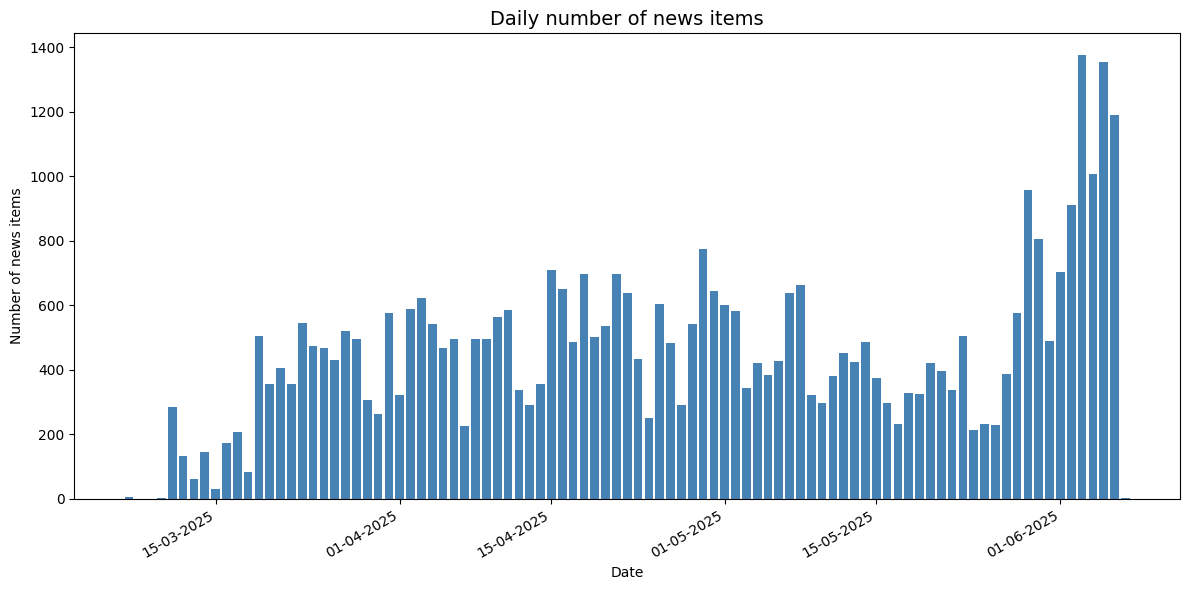

In [ ]:

# %%
# 2️⃣  LOAD the JSON and recreate the plot
plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])

fig, ax = plt.subplots(figsize=(12, 6))
ax = plot_from_d(df_loaded, plot_d_loaded, ax, color="steelblue")
plt.tight_layout()
plt.show()


In [ ]:
# %%
# ────────────────────────────────────────────────────────────
# LANGUAGE news counts over time  (grouped by language)
# ────────────────────────────────────────────────────────────

# 1️⃣  SAVE data + metadata → language_news_counts.json
# Group by date and language, count the number of news items for each combination
lang_counts_df = (
    df_window.groupby(["date", "language"])
             .size()
             .reset_index(name="news_count")
)
# Pivot to have each language as a separate column (for time series per language)
pivot_lang = lang_counts_df.pivot(index="date", columns="language", values="news_count").fillna(0)
pivot_lang.sort_index(inplace=True)
num_lang = pivot_lang.shape[1]
if num_lang > 10:
    print(f"📊 {num_lang} languages found. All languages included in JSON (visualization will default to top 10 with 'Other'; configurable).")
else:
    print(f"📊 {num_lang} languages found. All languages included in JSON.")
# Include all languages in JSON (no top 10 filtering during export)
pivot_lang_final = pivot_lang.astype(int)
pivot_lang_final.columns.name = None
pivot_lang_final_reset = pivot_lang_final.reset_index()
if pivot_lang_final_reset.columns[0] != "date":
    pivot_lang_final_reset = pivot_lang_final_reset.rename(columns={"index": "date"})

# Save the data and metadata to JSON
plot_path = Path("language_news_counts.json")
plot_d = {
    "data"      : pl.from_pandas(pivot_lang_final_reset).to_dict(as_series=False),
    "title"     : "Daily number of news items by language",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,             # Multiple series (one per language)
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


📊 17 languages found. All languages included in JSON (visualization will default to top 10 with 'Other'; configurable).
💾 JSON saved → /home/kadkhoda/language_news_counts.json


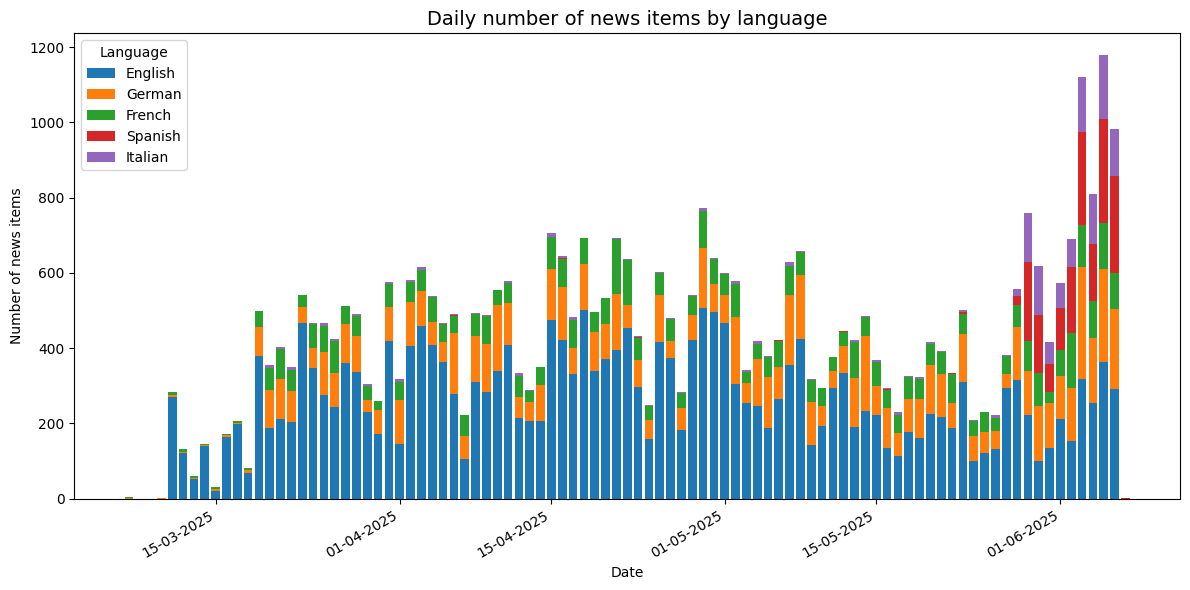

In [ ]:
# %%
# 2️⃣  LOAD the JSON and recreate the plot
TOP_N = 5  # Number of top languages to display in plot
INCLUDE_OTHER = False  # Whether to include an aggregated 'Other' category in addition to top languages

plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
# Prepare top languages and optional 'Other' for stacked bar
sums = df_loaded_pd.drop(columns=["date"]).sum()
if len(sums) > TOP_N:
    top_langs = sums.nlargest(TOP_N).index.tolist()
    other_langs = [col for col in df_loaded_pd.columns if col not in top_langs and col != "date"]
    df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
    for col in top_langs:
        df_plot[col] = df_loaded_pd[col]
    if INCLUDE_OTHER:
        df_plot["Other"] = df_loaded_pd[other_langs].sum(axis=1)
        categories = top_langs + ["Other"]
    else:
        categories = top_langs
else:
    df_plot = df_loaded_pd.copy()
    categories = [col for col in df_loaded_pd.columns if col != "date"]
# Plot stacked bars for languages
bottom = np.zeros(len(df_plot))
for category in categories:
    ax.bar(df_plot["date"], df_plot[category], bottom=bottom, label=str(category))
    bottom += df_plot[category].to_numpy()
# Set labels and title
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
ax.legend(title="Language")
plt.tight_layout()
plt.show()


In [ ]:
# %%
# ────────────────────────────────────────────────────────────
# COUNTRY news counts over time  (grouped by source country)
# ────────────────────────────────────────────────────────────

# 1️⃣  SAVE data + metadata → country_news_counts.json
# Group by date and source country, count the number of news items for each combination
country_counts_df = (
    df_window.groupby(["date", "sourcecountry"])
             .size()
             .reset_index(name="news_count")
)
pivot_country = country_counts_df.pivot(index="date", columns="sourcecountry", values="news_count").fillna(0)
pivot_country.sort_index(inplace=True)
num_countries = pivot_country.shape[1]
if num_countries > 10:
    print(f"📊 {num_countries} countries found. All countries included in JSON (visualization will default to top 10 with 'Other'; configurable).")
else:
    print(f"📊 {num_countries} countries found. All countries included in JSON.")
# Include all countries in JSON (no top 10 filtering during export)
pivot_country_final = pivot_country.astype(int)
pivot_country_final.columns.name = None
pivot_country_final_reset = pivot_country_final.reset_index()
if pivot_country_final_reset.columns[0] != "date":
    pivot_country_final_reset = pivot_country_final_reset.rename(columns={"index": "date"})

plot_path = Path("country_news_counts.json")
plot_d = {
    "data"      : pl.from_pandas(pivot_country_final_reset).to_dict(as_series=False),
    "title"     : "Daily number of news items by country",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


📊 13 countries found. All countries included in JSON (visualization will default to top 10 with 'Other'; configurable).
💾 JSON saved → /home/kadkhoda/country_news_counts.json


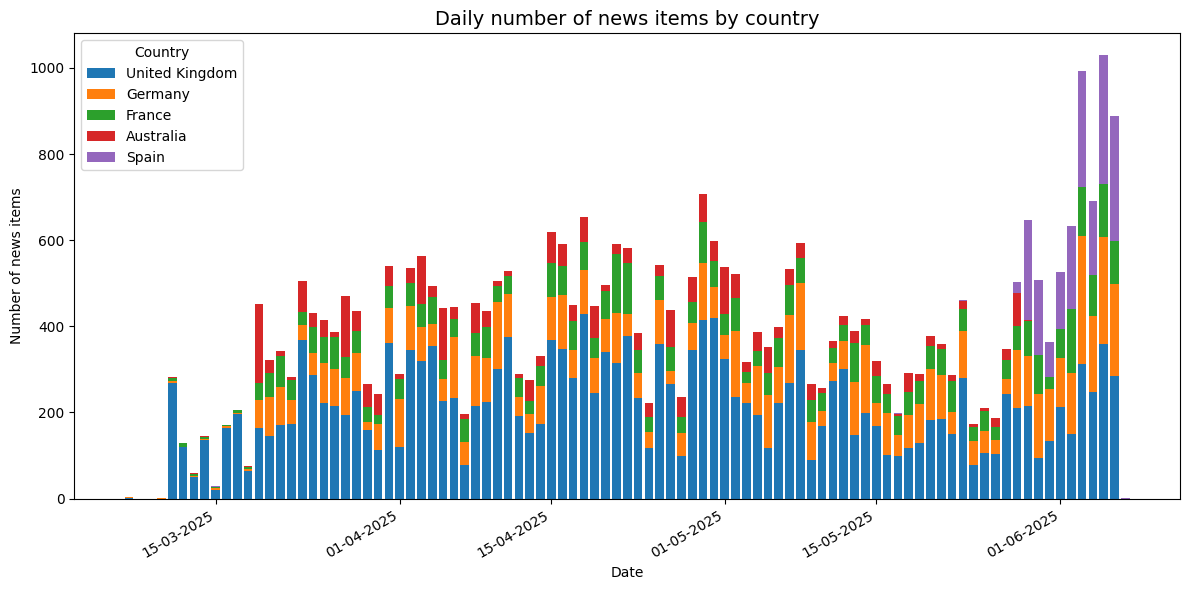

In [ ]:
# %%
# 2️⃣  LOAD the JSON and recreate the plot
TOP_N = 5  # Number of top countries to display in plot
INCLUDE_OTHER = False  # Whether to include an aggregated 'Other' category for remaining countries

plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
# Prepare top countries and optional 'Other' for stacked bar
sums = df_loaded_pd.drop(columns=["date"]).sum()
if len(sums) > TOP_N:
    top_countries = sums.nlargest(TOP_N).index.tolist()
    other_countries = [col for col in df_loaded_pd.columns if col not in top_countries and col != "date"]
    df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
    for col in top_countries:
        df_plot[col] = df_loaded_pd[col]
    if INCLUDE_OTHER:
        df_plot["Other"] = df_loaded_pd[other_countries].sum(axis=1)
        categories = top_countries + ["Other"]
    else:
        categories = top_countries
else:
    df_plot = df_loaded_pd.copy()
    categories = [col for col in df_loaded_pd.columns if col != "date"]
# Plot stacked bars for countries
bottom = np.zeros(len(df_plot))
for category in categories:
    ax.bar(df_plot["date"], df_plot[category], bottom=bottom, label=str(category))
    bottom += df_plot[category].to_numpy()
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
ax.legend(title="Country")
plt.tight_layout()
plt.show()


In [ ]:

# %%
# ────────────────────────────────────────────────────────────
# TOPIC news counts over time  (grouped by topic)
# ────────────────────────────────────────────────────────────

# 1️⃣  SAVE data + metadata → topic_news_counts.json
# Group by date and topic, count the number of news items for each combination
topic_counts_df = (
    df_window.groupby(["date", "topic"])
             .size()
             .reset_index(name="news_count")
)
pivot_topic = topic_counts_df.pivot(index="date", columns="topic", values="news_count").fillna(0)
pivot_topic.sort_index(inplace=True)
num_topics = pivot_topic.shape[1]
if num_topics > 10:
    print(f"📊 {num_topics} topics found. All topics included in JSON (visualization will default to top 10 with 'Other'; configurable).")
else:
    print(f"📊 {num_topics} topics found. All topics included in JSON.")
# Include all topics in JSON
pivot_topic_final = pivot_topic.astype(int)
pivot_topic_final.columns.name = None
pivot_topic_final_reset = pivot_topic_final.reset_index()
if pivot_topic_final_reset.columns[0] != "date":
    pivot_topic_final_reset = pivot_topic_final_reset.rename(columns={"index": "date"})

plot_path = Path("topic_news_counts.json")
plot_d = {
    "data"      : pl.from_pandas(pivot_topic_final_reset).to_dict(as_series=False),
    "title"     : "Daily number of news items by topic",
    "xlabel"    : "Date",
    "ylabel"    : "Number of news items",
    "x_data"    : "date",
    "y_data"    : None,
    "chart_type": "bar",
    "platform"  : "News",
}
save_dict(plot_d, plot_path)
print(f"💾 JSON saved → {plot_path.resolve()}")


📊 3 topics found. All topics included in JSON.
💾 JSON saved → /home/kadkhoda/topic_news_counts.json


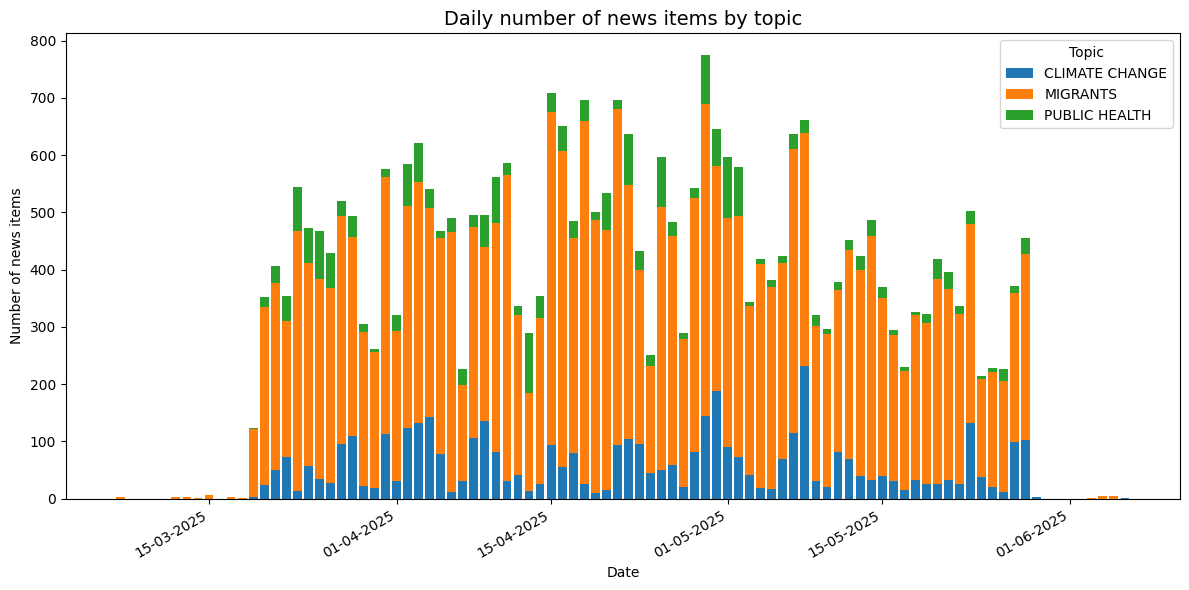

In [ ]:


# %%
# 2️⃣  LOAD the JSON and recreate the plot
TOP_N = 10  # Number of top topics to display in plot
INCLUDE_OTHER = True  # Whether to include an aggregated 'Other' category for remaining topics

plot_d_loaded = load_dict(plot_path)
df_loaded = df_from_data_d(plot_d_loaded["data"])
df_loaded_pd = df_loaded.to_pandas()
df_loaded_pd.sort_values("date", inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
# Prepare top topics and optional 'Other' for stacked bar
sums = df_loaded_pd.drop(columns=["date"]).sum()
if len(sums) > TOP_N:
    top_topics = sums.nlargest(TOP_N).index.tolist()
    other_topics = [col for col in df_loaded_pd.columns if col not in top_topics and col != "date"]
    df_plot = pd.DataFrame({"date": df_loaded_pd["date"]})
    for col in top_topics:
        df_plot[col] = df_loaded_pd[col]
    if INCLUDE_OTHER:
        df_plot["Other"] = df_loaded_pd[other_topics].sum(axis=1)
        categories = top_topics + ["Other"]
    else:
        categories = top_topics
else:
    df_plot = df_loaded_pd.copy()
    categories = [col for col in df_loaded_pd.columns if col != "date"]
# Plot stacked bars for topics
bottom = np.zeros(len(df_plot))
for category in categories:
    ax.bar(df_plot["date"], df_plot[category], bottom=bottom, label=str(category))
    bottom += df_plot[category].to_numpy()
ax.set_xlabel(plot_d_loaded.get("xlabel"))
ax.set_ylabel(plot_d_loaded.get("ylabel"))
ax.set_title(plot_d_loaded.get("title"), fontsize=14)
_maybe_format_date_axis(ax, df_plot["date"])
ax.legend(title="Topic")
plt.tight_layout()
plt.show()
